## Multi-Class Dog Breed Classification using Tensorflow and TensorflowHub

##### Dataset : https://www.kaggle.com/competitions/dog-breed-identification/data
    Training Set ~ 10,000 images
    Test Set ~ 10,000 images

Output : A file containing prediction probabilities of each dog breed for each sample.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import os

In [2]:
labels_csv = pd.read_csv("labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64


<Axes: xlabel='breed'>

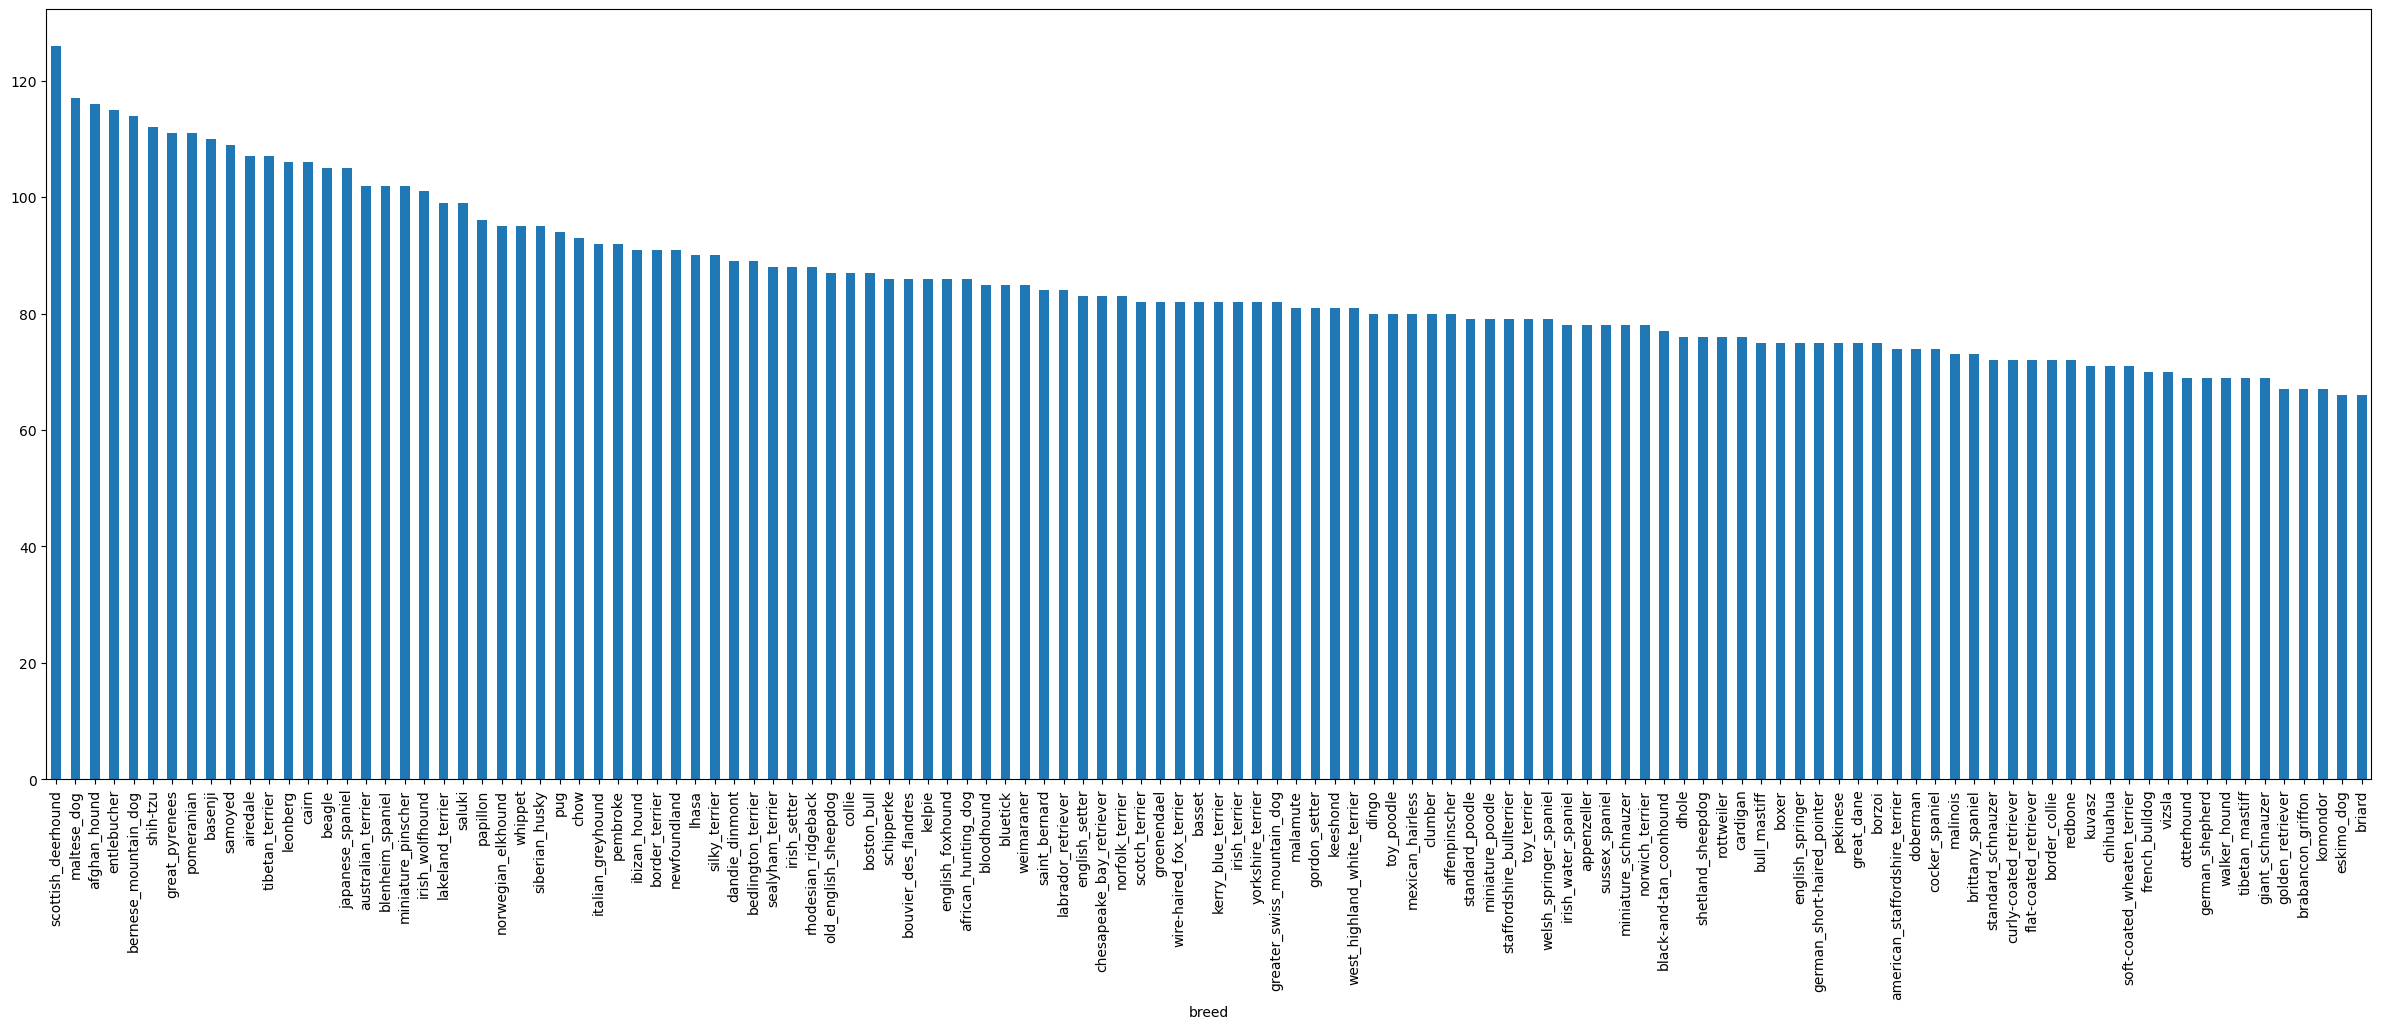

In [3]:
print(labels_csv["breed"].value_counts())
labels_csv["breed"].value_counts().plot.bar(figsize=(30,10))

In [4]:
# Get a list of all image labels with path appended
filenames = list("train/" + labels_csv["id"]+".jpg")
len(filenames)

10222

In [5]:
unique_breeds = np.unique(labels_csv['breed'])
len(unique_breeds)

120

In [6]:
labels = list(labels_csv["breed"])

In [7]:
# create a boolean array for each entry in the training set 
boolean_labels = [lab == unique_breeds for lab in labels]
np.shape(boolean_labels)

(10222, 120)

In [8]:
# Define Features and Target
x = filenames
y = list(boolean_labels)

In [9]:
# Set number of images for experimentation:  
num_images = 1000

In [10]:
# Split into Train and Validation Sets
from sklearn.model_selection import train_test_split
tx,vx,ty,vy = train_test_split(x[:num_images],y[:num_images],test_size = 0.2, random_state=42)

Preprocess Images : 

1. Input filnename
2. Convert Image into Tensors
3. Normalise the image RGB values
4. Resize the image into (224,224)
5. Return modified Image

In [11]:
# example of conversion of an image to tensor
from PIL import Image
img1 = Image.open(filenames[0])
img1_np = np.array(img1)
img1_t = tf.convert_to_tensor(img1_np)
print(img1_t)

tf.Tensor(
[[[109  46   0]
  [153  91  40]
  [180 120  68]
  ...
  [176 144  71]
  [189 157  84]
  [214 182 109]]

 [[153  92  47]
  [179 121  75]
  [167 111  64]
  ...
  [167 135  58]
  [171 139  62]
  [188 156  79]]

 [[152  97  56]
  [189 136  94]
  [164 113  70]
  ...
  [200 168  81]
  [194 162  75]
  [200 168  81]]

 ...

 [[189 122  69]
  [186 119  66]
  [183 116  63]
  ...
  [213 160 108]
  [212 159 107]
  [209 156 104]]

 [[186 119  66]
  [184 117  64]
  [183 116  63]
  ...
  [197 145  88]
  [199 147  90]
  [199 147  90]]

 [[182 115  62]
  [181 114  61]
  [183 116  63]
  ...
  [184 132  74]
  [190 138  80]
  [192 140  82]]], shape=(375, 500, 3), dtype=uint8)


In [12]:
# creating a fucntion that pre-processes images

img_size = 224

def process_images(path):

  # read image
  image = tf.io.read_file(path)

  # turn the image into a tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image , channels=3)

  # Normalise the tensor by converting RGB values from 0-255 to float 0-1 values
  # this makes computation easier
  image = tf.image.convert_image_dtype(image,tf.float32)

  # resize image to 224x224
  image = tf.image.resize(image , size = [img_size,img_size])

  return image

Split the data into bataches.
Batches consist of (image,label) tensors

In [13]:
def get_imagelabel(path , label):
  image = process_images(path)
  return image,label

Convert entire X and Y data into batches.

In [14]:
# define batch size
BATCH_SIZE = 32

def create_data_batch(x, y = None, batch_size = BATCH_SIZE , valid_data = False, test_data = False):
    
    # create batches of (image,label) pairs
    # shuffle data if training data , dont shuffle if test data
    
    # test data dosent contain labels
    if test_data:
        print("Creating test data batches...")
        # tf.data.Dataset creates a dataset ; .from_tensor_slices() : create dataset whose elements are slices of the given tensors.
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        # dataset.map(func) applies the func to elements of the dataset ; .batch(batch_size) : create batches of batch_size
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch

    elif valid_data : # dont shuffle validation data
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
        data_batch = data.map(get_imagelabel).batch(BATCH_SIZE)
        return data_batch

    else:  # training data , shuffle training data
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        # shuffle data before processing images (faster to do so)
        data = data.shuffle(buffer_size = len(x))  # shuffle the entire 'x' data
        data_batch = data.map(get_imagelabel).batch(BATCH_SIZE)
        return data_batch

In [15]:
# creating training and validation data batches
train_data = create_data_batch(tx,ty)
val_data = create_data_batch(vx,vy,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [16]:
train_data.element_spec , val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualise the data batches

In [17]:
import matplotlib.pyplot as plt

# create a function to display images in a data batch
def show_25_images(images,labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

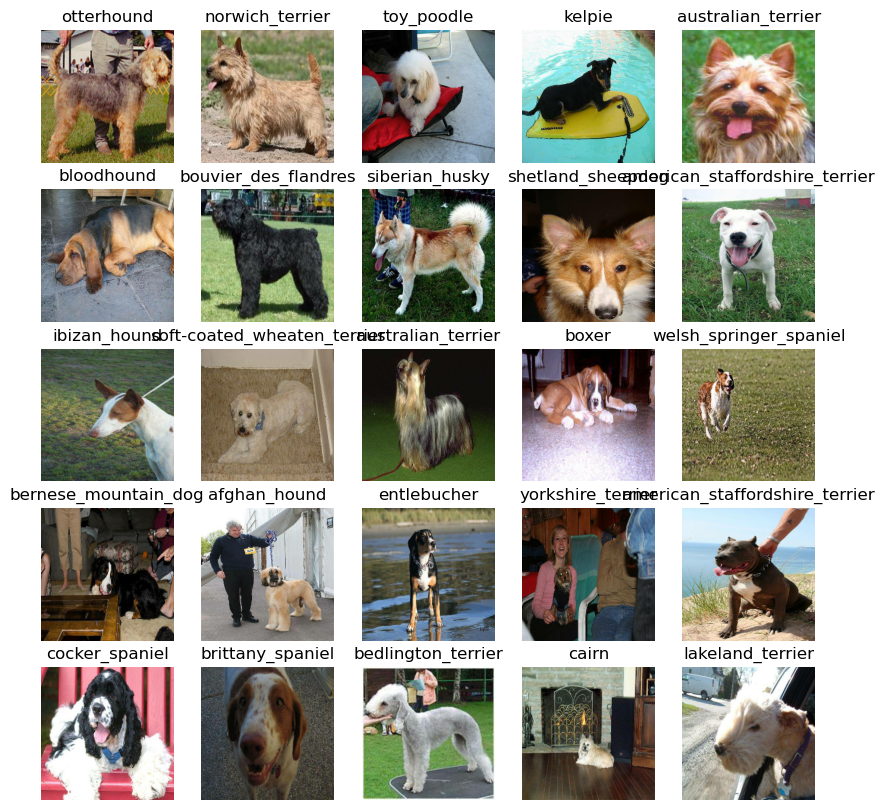

In [18]:
# visualise training images
train_images , train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

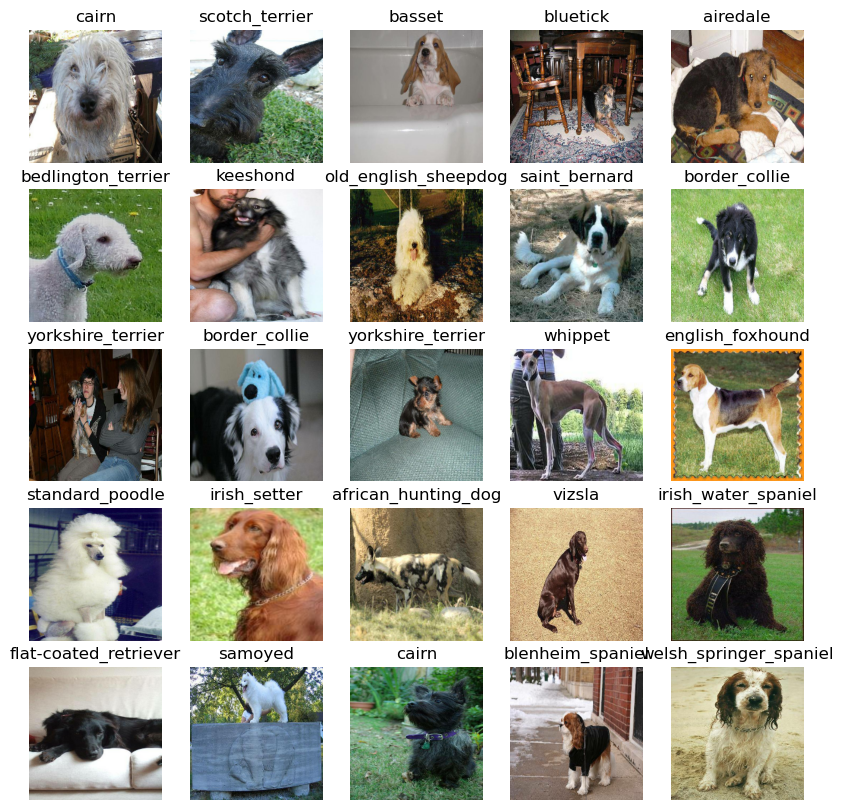

In [19]:
# visualise validation set
val_images , val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images , val_labels)

## Before building model define : 
    1. Input Shape to the model
    2. Output Shape (image labels in form of tensors)
    3. URL of model to use (Tensorflow Hub)

In [20]:
input_shape = [None , img_size , img_size , 3] # batch , height , width , color channels

output_shape = len(unique_breeds)

model_url = "https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2?tfhub-redirect=true"

In [21]:
# build a Keras Model
def create_model(input_shape = input_shape , output_shape = output_shape , model_url = model_url):
    print("Model Url : " , model_url)
    model = tf.keras.Sequential([hub.KerasLayer(model_url), # Layer 1 : Input Layer
                                tf.keras.layers.Dense(units = output_shape , activation = 'softmax')]) # Layer 2 : Output Layer

    model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])
    model.build(input_shape)
    return model

In [22]:
model = create_model()
model.summary()

Model Url :  https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2?tfhub-redirect=true
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


Model Explaination : 
* tf.keras.Sequential : Sequential groups a linear stack of layers into a Model
* hub.KerasLayer(model_url) :  preferred API to load a TF2-style SavedModel from TF Hub into a Keras model 
* tf.keras.layers.Dense(units = output_shape , activation = 'softmax') : By default , mobilenet_v2 outputs a array of size 1280  , but we need only 120
  outputs , so specify the number of units as the output_shape (120)
* Softmax Activation : The softmax function takes as input a vector z of K real numbers, and normalizes it into a probability distribution consisting     of K probabilities proportional to the exponentials of the input numbers. after applying softmax, each component will be in the interval (0,1) and      the components will add up to 1, so that they can be interpreted as probabilities.

  Usually for Binary Classification , the activation function is Sigmoid and the Loss func is Binary Crossentropy , but for
  Multi-Class Classification , the activation used is Softmax and Loss is Categorical Crossentropy.

* Categorical Cross - Entropy : 

  The Cross-entropy loss function quantifies the dissimilarity between the predicted probabilities and the true categorical labels. It  is commonly       used in neural networks with softmax activation in the output layer for multi-class classification tasks. By minimizing loss, the model learns to       assign higher probabilities to the correct class while reducing the probabilities for incorrect classes, improving accuracy.

* Adam Optimizer :

  The Adam optimizer, short for Adaptive Moment Estimation, is an iterative optimization algorithm used to minimize the loss function during the          training of neural networks1. It’s an extension to stochastic gradient descent.

  Adam is different from classical stochastic gradient descent. While stochastic gradient descent maintains a single learning rate for all weight         updates and the learning rate does not change during training, Adam maintains a learning rate for each network weight and adapts it as learning         unfolds.

  Adam combines the advantages of two other extensions of stochastic gradient descent:
    1. Momentum: This algorithm accelerates the gradient descent algorithm by considering the ‘exponentially weighted average’ of the gradients.
    2. Root Mean Square Propagation (RMSP): RMSprop is an adaptive learning algorithm that improves AdaGrad. Instead of taking the cumulative sum of            squared gradients like in AdaGrad, it takes the 'exponential moving average’

In [23]:
# creating callbacks 

# callback 1 : Tensorboard to track model progress

%load_ext tensorboard 
# load_ext tensorboard if not loaded already
import datetime
def create_tb_callback():
    # create a log directory to store TensorBoard logs
    logdir = os.path.join('logs',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)


# callback 2 : early stopping callback to prevent overfitting (stop training if a certain evaluation metric stops improving)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 3)

## Training Model (on 1000 images initiallly)
    Total images      = no of training steps(25)  * batch_size(32) = 800 images   # no of batches * batch size
    Validation images = no of validation steps(7) * batch_size(32) = 224 images   # no of batches * batch size

In [24]:
num_epochs = 100 # set number of epochs to 100 initially , change as needed
with tf.device('/GPU:0'):
    

    def train_model():
        # create model 
        model = create_model()
        # create tensorboard session everytime model is trained
        tensorboard = create_tb_callback()
        # fit model 
        model.fit(x = train_data , epochs = num_epochs , validation_data = val_data , validation_freq = 1,
                 callbacks = [tensorboard , early_stopping])

        return model

In [25]:
# fit model to data
model = train_model()

Model Url :  https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2?tfhub-redirect=true
Epoch 1/100
25/25 [==============================] - 16s 129ms/step - loss: 4.7118 - accuracy: 0.0875 - val_loss: 3.5218 - val_accuracy: 0.2300
Epoch 2/100
25/25 [==============================] - 2s 74ms/step - loss: 1.6996 - accuracy: 0.6725 - val_loss: 2.1553 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 2s 75ms/step - loss: 0.5855 - accuracy: 0.9425 - val_loss: 1.6257 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 2s 74ms/step - loss: 0.2587 - accuracy: 0.9875 - val_loss: 1.4525 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 2s 73ms/step - loss: 0.1476 - accuracy: 0.9975 - val_loss: 1.3564 - val_accuracy: 0.6650
Epoch 6/100
25/25 [==============================] - 2s 73ms/step - loss: 0.1020 - accuracy: 1.0000 - val_loss: 1.3225 - val_accuracy: 0.6600
Epoch 7/100
25/25 [=======

## Model is Overfitting as performance is 100% on training set but ~60-70% on the validation set

In [27]:
# check tensorboard logs
%tensorboard --logdir logs --host "0.0.0.0" --port 6006

Reusing TensorBoard on port 6006 (pid 1452), started 1 day, 20:02:34 ago. (Use '!kill 1452' to kill it.)

In the epoch_accuracy , the train accuracy is goving up very rapidly compared to validation data , model is learning data
instead of finding patterns.

## Make , Evaluate Predictions using a tarined model

In [28]:
# make predictions on the validation data :
predictions = model.predict(val_data , verbose = 1)
predictions

7/7 [==============================] - 1s 77ms/step


array([[1.33180935e-02, 3.20763502e-04, 2.80652457e-04, ...,
        4.19527671e-04, 8.00283742e-05, 6.86642574e-03],
       [8.32982268e-03, 1.88300596e-03, 3.55611332e-02, ...,
        1.25253550e-03, 1.30687456e-03, 4.27082152e-04],
       [2.21968367e-06, 2.40676163e-04, 2.86386421e-05, ...,
        3.33088028e-05, 5.91983153e-05, 4.22848243e-04],
       ...,
       [6.51756238e-07, 4.04693965e-05, 4.64939803e-05, ...,
        1.84583623e-05, 9.08664606e-06, 3.88677036e-05],
       [1.90964108e-03, 2.57531850e-04, 1.93576896e-04, ...,
        9.95769864e-04, 3.70112743e-04, 1.19813373e-02],
       [1.42575736e-04, 5.70077791e-05, 1.04806875e-03, ...,
        5.56519302e-03, 1.43765670e-03, 4.45449172e-04]], dtype=float32)

So for each validation image , 120 prediction probabilites are generated : check predictions.shape

In [29]:
# check a prediction vs actual value
print("Label : ", unique_breeds[42])
print("Predicted : ", unique_breeds[np.argmax(predictions[42])])

Label :  entlebucher
Predicted :  walker_hound


In [30]:
def get_pred_labels(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]
print(get_pred_labels(predictions[81]))

dingo


## To compare the Validation Images labels and predicted labels , first unbatch the validation data

In [31]:
def unbatchify(data):
    images_ ,lables_ = [], []
    for image,label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        lables_.append(unique_breeds[np.argmax(label)])
    return images_ , lables_

val_images , val_labels = unbatchify(val_data)

In [32]:
val_images[0] , val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [33]:
get_pred_labels(val_labels[0]) , get_pred_labels(predictions[0])

('affenpinscher', 'cairn')

## Visualise predicted label , truth label , predicted probability along with an image

In [34]:
def plotimg(predictions , labels , images , n):
    pred_prob , true_label , image = predictions[n] , labels[n] , images[n]
    pred_label = get_pred_labels(pred_prob)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    # if predicted correctly title is green else red
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.title("True : "+true_label ,color = color)
    plt.xlabel("Predicted : {} , Prob: {:2.0f}%".format(pred_label , np.max(pred_prob*100)) , color = color)

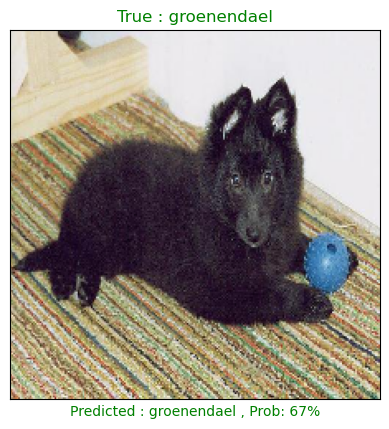

In [35]:
plotimg(predictions , val_labels , val_images , 77)

## Visualise top 10 predictions                 

In [36]:
def plot_top_10(predictions,labels,n):
    pred_prob , true_label = predictions[n] , labels[n]
    pred_label = get_pred_labels(pred_prob)

    # find top 10 predictions
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # plot top 10
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)) , top_10_pred_values , color= 'grey')
    plt.xticks(np.arange(len(top_10_pred_labels)) , labels = top_10_pred_labels , rotation = 60)

    if np.isin(true_label , top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")


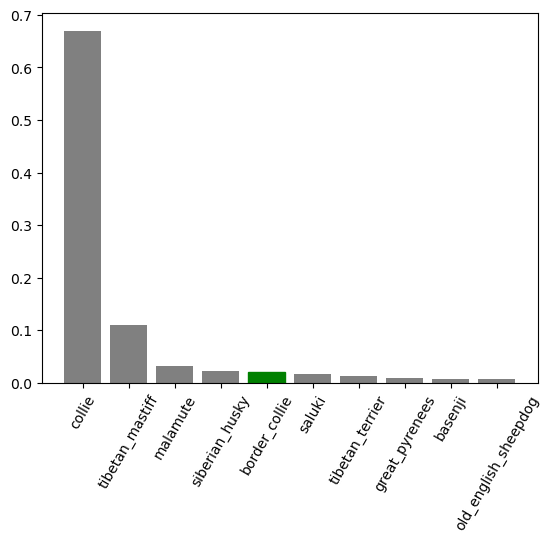

In [37]:
plot_top_10(predictions , val_labels, 9)

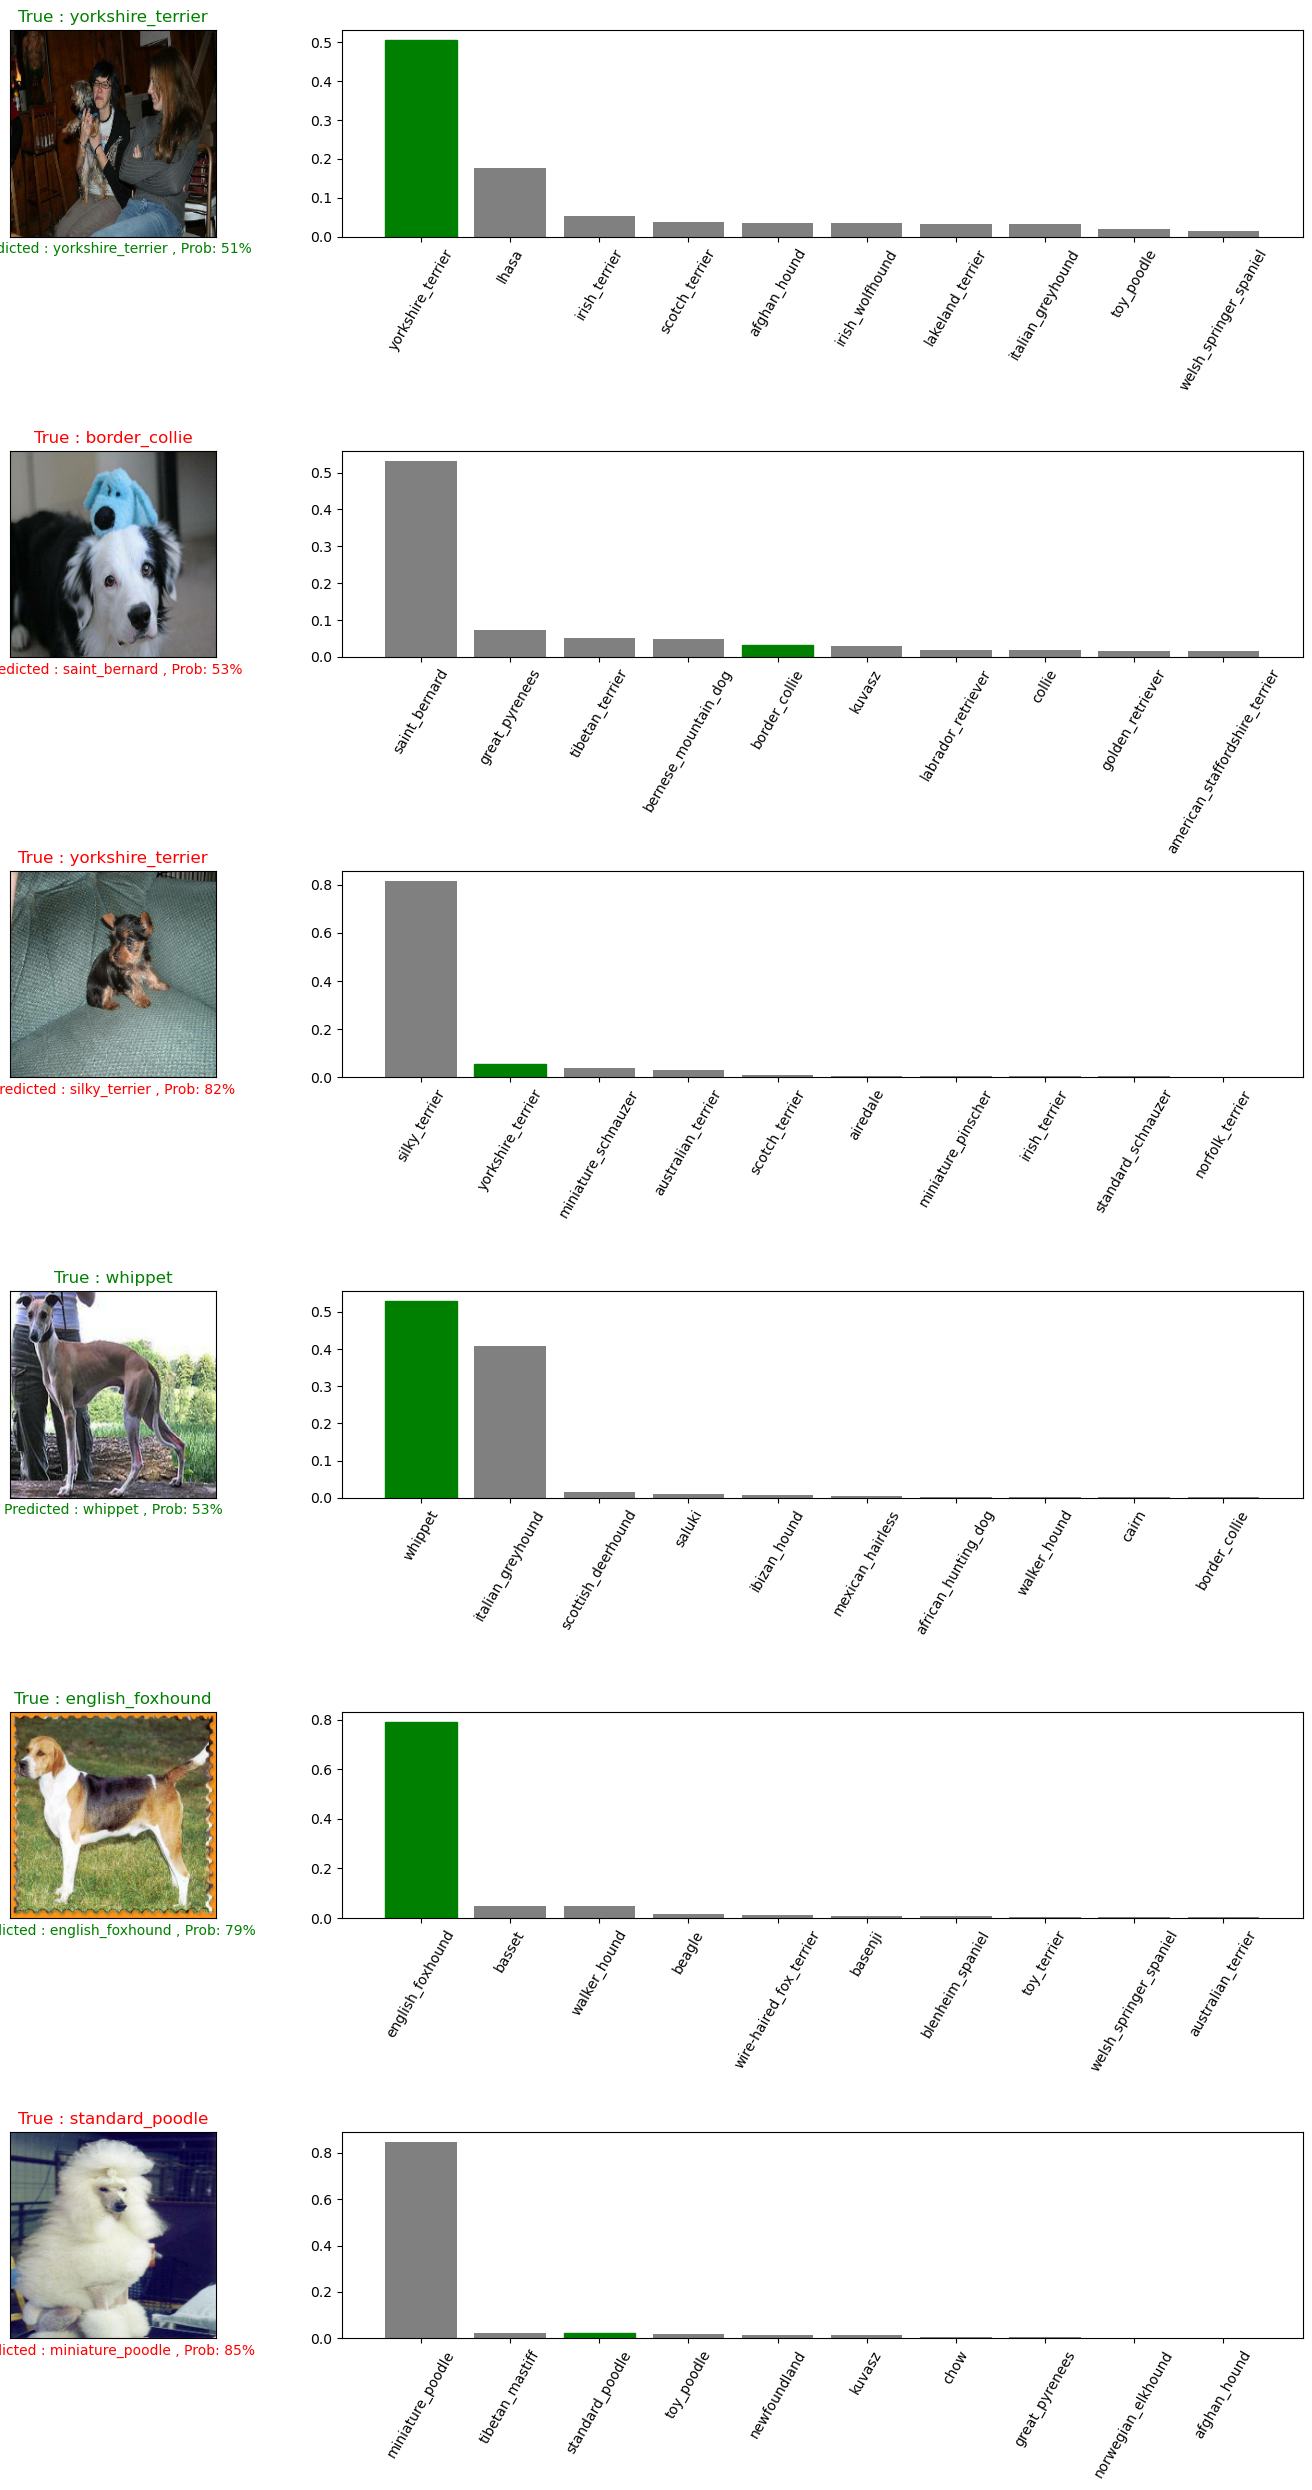

In [38]:
i_mul = 10
rows  = 3
cols = 2
num_images = rows*cols
plt.figure(figsize = (17,25))
for i in range(num_images):
    plt.subplot(rows * 2 , cols , 2*i + 1)
    plotimg(predictions, val_labels , val_images ,i+i_mul)
    plt.subplot(rows * 2 , cols , 2*i + 2)
    plot_top_10(predictions , val_labels , i + i_mul)
    plt.tight_layout()
plt.show()


## Save and reload trained model

In [69]:
def save_model(model , suffix = None):
    model_dir = os.path.join(os.path.join("models") , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = model_dir + suffix + ".h5"
    print("Saving model to " , model_path + "...")
    model.save(model_path)
    return model_path

In [70]:
def load_model(model_path):
    print("Loading model from : " , model_path)
    model = tf.keras.models.load_model(model_path , custom_objects={"KerasLayer" : hub.KerasLayer}) # custom_objects field as a tensorflowhub model is used
    return model

In [71]:
save_model(model , suffix = "1000-images-adam")

Saving model to  models\20240605-1224091000-images-adam.h5...


'models\\20240605-1224091000-images-adam.h5'

In [73]:
loaded = load_model('models\\20240605-1224091000-images-adam.h5')

Loading model from :  models\20240605-1224091000-images-adam.h5


In [51]:
model.evaluate(val_data)

7/7 [==============================] - 1s 52ms/step - loss: 1.3380 - accuracy: 0.6350


[1.3379559516906738, 0.6349999904632568]

In [76]:
loaded.evaluate(val_data)

7/7 [==============================] - 1s 51ms/step - loss: 1.2874 - accuracy: 0.6500


[1.287358283996582, 0.6499999761581421]

## Train Model on Full Data

In [39]:
full_data = create_data_batch(x,y)

Creating training data batches...


In [40]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [41]:
full_model = create_model()

Model Url :  https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2?tfhub-redirect=true


In [42]:
full_model_tb = create_tb_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy' , patience = 3)

In [43]:
full_model.fit(full_data , epochs = num_epochs , callbacks= [full_model_tb , full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 22s 55ms/step - loss: 1.3517 - accuracy: 0.6704
Epoch 2/100
320/320 [==============================] - 18s 56ms/step - loss: 0.4003 - accuracy: 0.8829
Epoch 3/100
320/320 [==============================] - 18s 56ms/step - loss: 0.2389 - accuracy: 0.9339
Epoch 4/100
320/320 [==============================] - 18s 56ms/step - loss: 0.1539 - accuracy: 0.9638
Epoch 5/100
320/320 [==============================] - 18s 56ms/step - loss: 0.1052 - accuracy: 0.9798
Epoch 6/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0761 - accuracy: 0.9877
Epoch 7/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0606 - accuracy: 0.9910
Epoch 8/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0463 - accuracy: 0.9932
Epoch 9/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0374 - accuracy: 0.9961
Epoch 10/100
320/320 [==============================] - 18s 56ms/step - l

In [82]:
save_model(full_model , suffix = 'full_images')

Saving model to  models\20240605-124731full_images.h5...


'models\\20240605-124731full_images.h5'

## Make Predictions on the Test Dataset

In [44]:
# process test data to pass it to model
test_path = 'test/'
test_filenames = [test_path + file_name for file_name in os.listdir(test_path)] # filenames = list("train/" + labels_csv["id"]+".jpg")
test_filenames

['test/000621fb3cbb32d8935728e48679680e.jpg',
 'test/00102ee9d8eb90812350685311fe5890.jpg',
 'test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'test/002f80396f1e3db687c5932d7978b196.jpg',
 'test/0036c6bcec6031be9e62a257b1c3c442.jpg',
 'test/0041940322116ae58c38130f5a6f71f9.jpg',
 'test/0042d6bf3e5f3700865886db32689436.jpg',
 'test/004476c96f575879af4af471af65cae8.jpg',
 'test/00485d47de966a9437ad3b33ac193b6f.jpg',
 'test/00496f65de6cc319145ce97bd6e90360.jpg',
 'test/004bf14426d1a830d459a9e0c0721309.jpg',
 'test/004c3721eb88358f462cdcec6b2380b7.jpg',
 'test/00559f56aab7e0a7749220f6aed65162.jpg',
 'test/005b281f1a4d6f29d527c9585e9bd33c.jpg',
 'test/005b6c6c76fefd6b458ef6fb6e54da6e.jpg',
 'test/006870b49353779b25eeb91fed43c31a.jpg',
 'test/0068f3a21b159ece126a28580cd

In [45]:
len(test_filenames)

10357

In [46]:
test_data = create_data_batch(test_filenames , test_data= True)

Creating test data batches...


In [47]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [48]:
test_predctions = full_model.predict(test_data , verbose = 1)

324/324 [==============================] - 18s 53ms/step


In [84]:
np.savetxt("test_predictions.csv", test_predctions, delimiter=",")

In [86]:
test_predictions = np.loadtxt("test_predictions.csv" ,delimiter=",")

In [87]:
test_predictions[:10]

array([[6.74196213e-13, 1.54866341e-13, 1.65653148e-16, ...,
        8.09883776e-15, 1.26775257e-11, 2.17620323e-12],
       [1.66220173e-06, 1.84315081e-06, 4.55246107e-09, ...,
        1.88524543e-11, 1.23098800e-07, 2.81863699e-10],
       [1.79385846e-11, 7.93901449e-07, 6.90434931e-10, ...,
        8.81985329e-07, 6.27354280e-11, 2.77941992e-12],
       ...,
       [1.60796854e-09, 1.61900965e-10, 1.63984694e-11, ...,
        1.31942395e-12, 1.46918903e-12, 3.89991615e-11],
       [3.08025341e-11, 1.46420778e-10, 2.19099988e-10, ...,
        8.46350815e-07, 2.79839640e-09, 1.86715313e-11],
       [4.87930452e-09, 2.13615861e-11, 1.01288575e-10, ...,
        1.12610323e-12, 1.20439950e-10, 1.66666084e-07]])

In [88]:
test_predictions.shape

(10357, 120)

In [105]:
preds_df = pd.DataFrame(columns = ["id"] + list(unique_breeds))

In [111]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df[list(unique_breeds)] = test_predctions

In [114]:
preds_df.to_csv("Submission1.csv" , index = False)

In [118]:
full_model.evaluate(test_data)

324/324 [==============================] - 6s 18ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [119]:
len(full_data)

320

## Predictions on User Images

In [49]:
us_path = "user images/"
us_filenames = [us_path + fname for fname in os.listdir(us_path)]
us_filenames

['user images/download (1).jpeg',
 'user images/download (2).jpeg',
 'user images/download.jpeg']

In [50]:
# create batches
us_data = create_data_batch(us_filenames , test_data=True)

Creating test data batches...


In [51]:
us_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [52]:
us_pred = full_model.predict(us_data)
us_pred.shape

1/1 [==============================] - 0s 103ms/step


(3, 120)

In [58]:
us_pred_labels = [get_pred_labels(us_pred[i]) for i in range(len(us_pred))]
us_pred_labels

['norfolk_terrier', 'french_bulldog', 'american_staffordshire_terrier']

In [59]:
(len(us_pred))

3

In [60]:
us_images = []
for img in us_data.unbatch().as_numpy_iterator():
    us_images.append(img)

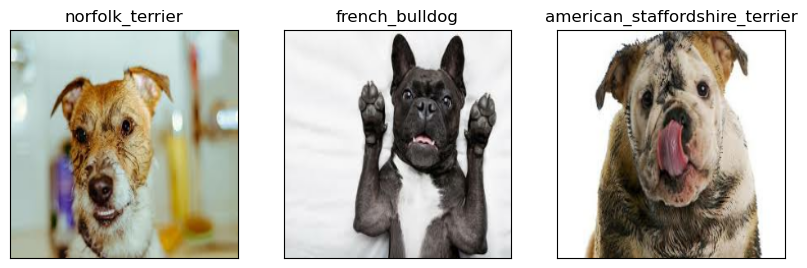

In [61]:
plt.figure(figsize=(10,10))
for i,img in enumerate(us_images):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(us_pred_labels[i])
    plt.imshow(img)